<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L07/data_driven_robust_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To illustrate the theory, we consider first a very specialized family of robust convex programs, namely robust linear programs of the form:

$$ \min_{x\in\mathcal{A}} c^T x ~~ \text{ subject to }~~  A(u)x\leq b  ~~\forall~~~ u \in \mathcal{U} $$


For particular uncertainty structures, e.g., $A(u)$ is affine in $u$ and the set  $\mathcal{U}$ is closed convex, we can find the solution of the problem above exactly by reformulating it as a convex optimization problem.





However, if the dependency of $A(u)$ on $u$ is not affine or the set $\mathcal{U}$ does not have a nice structure, we can only work with approximated solutions.


A data-driven approximation of the problem aboved is:

$$ \min_{x\in\mathcal{A}} c^T x ~~ \text{ subject to }~~  A(u)x\leq b  ~~\forall~~~ \color{blue}{u \in \mathcal{D}}$$


where $\mathcal{D}$ is a finite set of samples observed from $\mathcal{U}$ (with an underlying unknown probability)

The same way of writing this data driven problem is:

$$ \min_{x\in\mathcal{A}} c^T x$$
$$\text{ subject to } $$
$$A(u^{(1)})a\leq b$$
$$A(u^{(2)})a\leq b$$
$$\cdots$$
$$A(u^{(N)})a\leq b$$

where the sample in $\mathcal{D}$, indexed via the notation $u^{(i)}, i =1,..,N$, define $N$ deterministic constraints in the optimization problem.

In [3]:
#@title let us consider a simple linear optimization problem


import numpy as np
from scipy.optimize import linprog
from scipy.stats import norm

n_samples = 2000
n_dim = 2
n_constraints = 4

# Define coefficients matrix
A_nominal = np.array([[-1.0, 0.],
                      [0., -1.],
                      [1., 0.],
                      [0., 1.]])


# Define the objective function coefficients
c = np.array([-1, -1])

# Define the inequality constraints
b = np.array([0, 0, 1, 1])


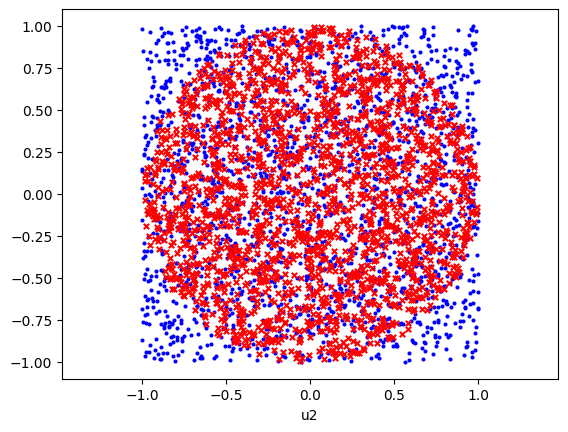

In [5]:
#@title Visualize Data Generation Mechanism

def sample_ball(dim=2):
    """Uniformly sample from 2D unit ball"""
    vec = np.random.randn(dim)
    vec /= np.linalg.norm(vec)  # Random direction
    r = np.random.uniform() ** (1/dim)  # Scale for uniform volume
    return vec * r

def sample_box(dim=2):
    """Uniformly sample from 2D unit ball"""
    return np.array([np.random.uniform(low=-1,high=1) for _ in range(dim)])  # sample uniformly distributed in [-1,+1]

# U_data = np.random.randn(n_samples,n_constraints,n_dim)*2-1
U_box_data = [np.array([sample_box() for _ in range(n_constraints)]) for _ in range(n_samples)]
U_ball_data = [np.array([sample_ball() for _ in range(n_constraints)]) for _ in range(n_samples)]


import matplotlib.pyplot as plt

u0 = [U_box_data[k][:, 0] for k in range(500)]
u1 = [U_box_data[k][:, 1] for k in range(500)]
plt.scatter(u0, u1, 15, marker='.', c='b')

u0 = [U_ball_data[k][:, 0] for k in range(500)]
u1 = [U_ball_data[k][:, 1] for k in range(500)]
plt.scatter(u0, u1, 15, marker='x', c='r')
plt.axis('equal')
plt.xlabel('u1')
plt.xlabel('u2')
plt.show()

In [1]:
U_data = U_ball_data

A_fun = lambda u :  A_nominal + 0.2* u.astype(float)

# Initialize the constraint matrix A
A_constraints = []

# Iterate through the data samples and create constraints
for i in range(n_samples):
  A_i = A_fun(U_data[i])
  A_constraints.append(A_i)

# Concatenate the constraints into a single matrix
A = np.concatenate(A_constraints)
print(np.shape(A))
# Solve the linear program
result = linprog(c, A_ub=A, b_ub=np.tile(b, n_samples), bounds=(None, None))


# Print the results
# print(result)
print("Optimal Objective Value:", result.fun)
print("Optimal Solution:", result.x)


(8000, 2)
Optimal Objective Value: -1.56328605752353
Optimal Solution: [0.78347794 0.77980812]


In [ ]:
import cvxpy as cp
import numpy as np
from scipy.stats import multivariate_normal
# ==============================
# Exact SOCP Solution
# ==============================
def exact_socp_solution():
    x = cp.Variable(2)
    A_nominal = np.array([[-1, 0], [0, -1], [1, 0], [0, 1]])
    b = np.array([0, 0, 1, 1])
    c = np.array([-1, -1])

    constraints = []
    for i in range(4):
        a_i = A_nominal[i, :]
        if i < 2:
            # First two rows: -x_i + 0.2||x|| <= 0
            constraints.append(a_i @ x + 0.2 * cp.norm(x) <= 0)
        else:
            # Last two rows: x_i + 0.2||x|| <= 1
            constraints.append(a_i @ x + 0.2 * cp.norm(x) <= 1)

    prob = cp.Problem(cp.Minimize(c.T @ x), constraints)
    prob.solve()
    return x.value, prob.value

# ==============================
# Randomized LP Solution
# ==============================

def randomized_lp_solution(N=20_000):
    x = cp.Variable(2)
    A_nominal = np.array([[-1, 0], [0, -1], [1, 0], [0, 1]])
    b = np.array([0, 0, 1, 1])
    c = np.array([-1, -1])

    # Generate N samples of delta (4 vectors per sample)
    deltas = [[sample_ball() for _ in range(4)] for _ in range(N)]

    # Build constraints: 4 constraints per sample
    constraints = []
    for delta in deltas:
        A_perturbed = A_nominal.copy().astype(float)
        for i in range(4):
            A_perturbed[i, :] += 0.2 * delta[i]
        for row in A_perturbed:
            constraints.append(row @ x <= b[i])

    prob = cp.Problem(cp.Minimize(c.T @ x), constraints)
    prob.solve(verbose=False)  # Use commercial solver for large N
    return x.value, prob.value

# ==============================
# Run and Compare
# ==============================
x_exact, obj_exact = exact_socp_solution()
x_rand, obj_rand = randomized_lp_solution(N=200)  # Reduced N for demonstration

print(f"Exact SOCP Solution: x = {x_exact}, Objective = {obj_exact}")
print(f"Randomized Samples LP Solution: x = {x_rand}, Objective = {obj_rand}")

Exact SOCP Solution: x = [0.77951879 0.77951879], Objective = -1.5590375813667334
Randomized LP Solution: x = [0.78325323 0.78474026], Objective = -1.5679934920862548
